In [1]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas
from matplotlib import pyplot as plt

To generate the dumps, do something like this
```fish
for GC in Serial Parallel G1 Z Shenandoah; taskset -c 0-7 /usr/lib/jvm/temurin-17-amd64/bin/java -server -XX:-TieredCompilation -Xcomp -XX:+UnlockExperimentalVMOptions -XX:+Use{$GC}GC -XX:ConcGCThreads=4 -XX:ParallelGCThreads=4 -Xms420M -Xmx420M -jar /usr/share/benchmarks/dacapo/dacapo-evaluation-git-29a657f.jar -n 5 lusearch -t 4 --dump-latency; mv scratch scratch-$GC; end
```

In [2]:
GCs = ["G1"]#, "Parallel", "Serial", "Shenandoah", "Z"]
buildstrings = ["lusearch.3023.70.jdk.g1.common.hs_perf.latency.dacapochopin-29a657f"]
invocations = 2
latency_types = ["metered", "simple"]
runid = 'fox-2021-11-19-Fri-121639'
folder = f'/home/wenyuz/MMTk-Dev/evaluation/results/log/{runid}'

In [3]:
def load_data(buildstring, invocation, latency_type, folder):
    df =  pandas.read_csv("{}/{}.{}/dacapo-latency-usec-{}.csv".format(folder, buildstring, invocation, latency_type), names=["start", "end"])
    df["latency"] = df["end"] - df["start"]
    return df


In [4]:
MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000*1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

In [5]:
histograms = {}
for GC in GCs:
    histograms[GC] = []
    for i in range(invocations):
        buildstring = buildstrings[GCs.index(GC)]
        histogram = HdrHistogram(MIN_LATENCY_USEC, MAX_LATENCY_USEC, LATENCY_SIGNIFICANT_DIGITS)
        latencies = load_data(buildstring, i, "metered", folder)["latency"]
        for l in latencies:
            histogram.record_value(l)
        histograms[GC].append(histogram)

In [6]:
percentile_list = []
for GC, histograms in histograms.items():
    for j, histogram in enumerate(histograms):
        for i in histogram.get_percentile_iterator(5):
            percentile_list.append({"GC": GC, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
percentile_df = pandas.DataFrame(percentile_list)
percentile_df["other"] = 1 / (1 - percentile_df["percentile"])

[Text(1, 0, '0'),
 Text(10, 0, '90'),
 Text(100, 0, '99'),
 Text(1000, 0, '99.9'),
 Text(10000, 0, '99.99'),
 Text(100000, 0, '99.999'),
 Text(1000000, 0, '99.9999')]

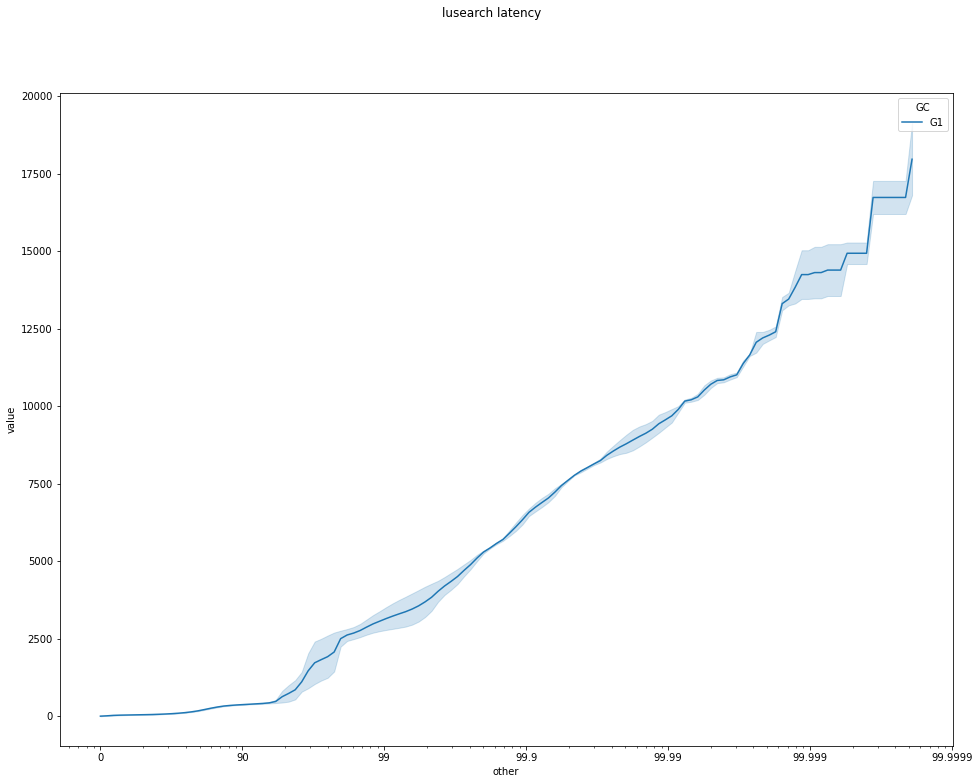

In [7]:
fig, ax = plt.subplots(1,1,figsize=(16,12))
fig.suptitle('lusearch latency')
sns.lineplot(data=percentile_df, x="other", y="value", hue="GC", ax=ax)
ax.set_xscale('log')
ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])
ax.set_xticklabels(['0', '90', '99', '99.9', '99.99', '99.999', '99.9999'])